In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import os

## Data Assembly

In [2]:
####assemble normalised data into data frames

#function to read in modelled decoding time data and normalise to mean
def read_rrt(p,file_name):
    df = pd.read_csv(p + file_name)
    av_dt = np.mean(df['average_decoding_time'])
    if not 'W' in file_name:
        colname = 'base config'
    else:
        colname = file_name[:-4].replace('Wo_','')
    df[colname] = df['average_decoding_time'] / av_dt
    
    return df[['codon',colname]]

#read in filenames
p = 'Data/base_pairing_decoding_times//'
file_names = os.listdir(p)
file_names = [file for file in file_names if file[0] == 'W']

#initiate dataframe with baseline data
norm_df = read_rrt(p,'base_configuration.csv')
for file_name in file_names:
    add_df = read_rrt(p,file_name)
    norm_df = norm_df.merge(add_df,on='codon')

#read in experimental RRT file names
p = 'Data/Experimental data/'
file_names = os.listdir(p)
file_names = [file for file in file_names if file[0] != '.']

#add experimental RRT data (RRTs are already normalised)
for file_name in file_names:
    add_df = pd.read_csv(p + file_name)
    add_df['codon'] = add_df['codon'].str.replace('T','U')
    add_df.columns = [add_df.columns[0],file_name[:-4]]
    norm_df = norm_df.merge(add_df,on='codon')

norm_df = norm_df.set_index('codon')
norm_df = norm_df.iloc[:,0:].T

<h2>MDS</h2>

In [3]:
#fit 2D mds
norm_mds = MDS(n_components=2,normalized_stress='auto',metric=True)
norm_mds_data = norm_mds.fit_transform(norm_df)

#identify MDs clusters
get_mds_clusters = DBSCAN(eps=0.2, min_samples=10).fit(norm_mds_data)

#compare distances in original and 2D datasets
mds_comp_x = euclidean_distances(norm_mds_data).flatten()
mds_comp_y = euclidean_distances(norm_df).flatten()

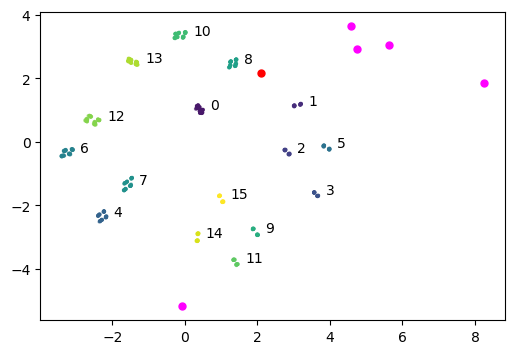

In [4]:
###Plot results

x = norm_mds_data.T[0]
y = norm_mds_data.T[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y,s=3,c=get_mds_clusters.labels_,cmap='viridis',alpha = 0.5)
ax.scatter(x[0],y[0],c='red',s=25)
ax.scatter(x[-5:],y[-5:],c='fuchsia',s=25)
#label individual clusters with their cluster number
for n in range(max(get_mds_clusters.labels_)+1):
    select_x = [a[0] for i,a in enumerate(norm_mds_data) if get_mds_clusters.labels_[i] == n]
    select_y = [a[1] for i,a in enumerate(norm_mds_data) if get_mds_clusters.labels_[i] == n]
    ax.text(max(select_x) + 0.2,np.mean(select_y),str(n))
plt.show()

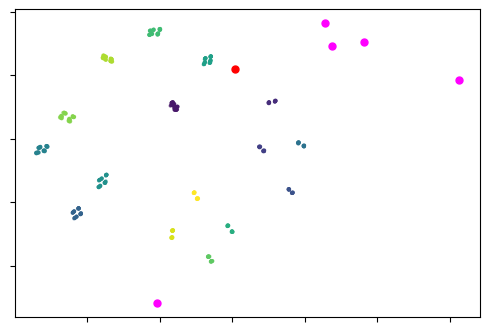

In [5]:
#plot .png version of figure without furniture to generate publication figure
#(svg version is ~300 mb)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y,s=3,c=get_mds_clusters.labels_,cmap='viridis',alpha = 0.5)
ax.scatter(x[0],y[0],c='red',s=25)
ax.scatter(x[-5:],y[-5:],c='fuchsia',s=25,)
ax.set_xticklabels([])
ax.set_yticklabels([])
#plt.savefig('Figure files/mds_bare.png',dpi=600)
plt.show()


<h2>Cluster composition</h2>
<p>Symbols used for non-standard nucleotides are:</p>
<table>
    <td>
        <ul>
            <li>1: mcm5U</li>
            <li>3: mcm5s2U</li>
            <li>I: inosine</li>
            <li>M: ac4C</i>
            <li>N: unkown modified U</li>
            <li>P: pseudouridine</li>
        </ul>
    </td>
    <td>
        <ul>        
            <li>Q: queuosine</li>
            <li>S: mnm5s2U</li>
            <li>V: cmo5U</li>
            <li>W: wybutosine</li>
            <li>{: mnm5U</li>
            <li>): cmnm5Um</li>
        </ul>
    </td>
    <td>
        <ul>
            <li>&: ncm5U</li>
            <li>~: ncm5Um</li>
            <li>.: unknown nucleotide</li>
            <li>?: m5C</li>
        </ul>
    </td>
</table>

In [6]:
def count_bp_labels(n):
    bp_labels = norm_df.index
    cluster_bp_labels = [bl for i,bl in enumerate(bp_labels) if get_mds_clusters.labels_[i] == n]
    results = {}
    for cbl in cluster_bp_labels:
        cbl_elements = cbl.split(' ')
        for el in cbl_elements:
            if el in results.keys():
                results[el] += 1
            else:
                results[el] = 1
    return results

In [7]:
#change the number assigned to n in order to see the composition of different clusters
n = 3
print('label no:' + str(n) + '.' + str(np.sum([1 for l in get_mds_clusters.labels_ if l == n])) + ' data points.')
print(count_bp_labels(n))

label no:3.32 data points.
{'A_A': 16, 'G_3': 32, 'G_~': 16, 'G_P': 16, 'U_I': 16, 'G_?': 16}
